In [ ]:
! pip install transformers
! pip install datasets

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
tokenizer.padding_side, tokenizer.vocab_size

('right', 50257)

In [ ]:
model.config

GPT2Config {
  "_attn_implementation_autoset": true,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1600,
  "n_head": 25,
  "n_inner": null,
  "n_layer": 48,
  "n_positions": 1024,
  "output_past": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "float32",
  "transformers_version": "4.51.1",
  "use_cache": true,
  "vocab_size": 50257
}

In [ ]:
import pandas as pd

In [ ]:
input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

In [ ]:
input_ids[0]

tensor([41762,   364,   389,   262], device='cuda:0')

In [ ]:
with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
            f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.26%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


In [ ]:
sorted_ids.shape, sorted_ids[None, 0, None], sorted_ids[0]

(torch.Size([50257]),
 tensor([[11]], device='cuda:0'),
 tensor(11, device='cuda:0'))

## getting output

In [ ]:
type(output), output.keys(), output.logits,  output.logits.shape

(transformers.modeling_outputs.CausalLMOutputWithCrossAttentions,
 odict_keys(['logits', 'past_key_values']),
 tensor([[[ 2.7388,  4.8211,  1.7156,  ..., -6.9956, -4.9382, -0.3056],
          [ 4.6024,  7.0256,  2.0684,  ..., -8.2232, -4.8386,  2.6589],
          [ 1.9228,  0.9972, -3.3385,  ..., -3.4645, -3.6465, -0.4307],
          [ 0.3186,  0.8100, -2.9974,  ..., -3.2712, -4.3837,  0.8114]]],
        device='cuda:0'),
 torch.Size([1, 4, 50257]))

In [ ]:
a= output.logits[0,-1,:]
print(a.shape, a)

torch.Size([50257]) tensor([ 0.3186,  0.8100, -2.9974,  ..., -3.2712, -4.3837,  0.8114],
       device='cuda:0')


In [ ]:
a.to('cpu').numpy()

array([ 0.31862503,  0.81004393, -2.997366  , ..., -3.2711663 ,
       -4.3837304 ,  0.8114318 ], dtype=float32)

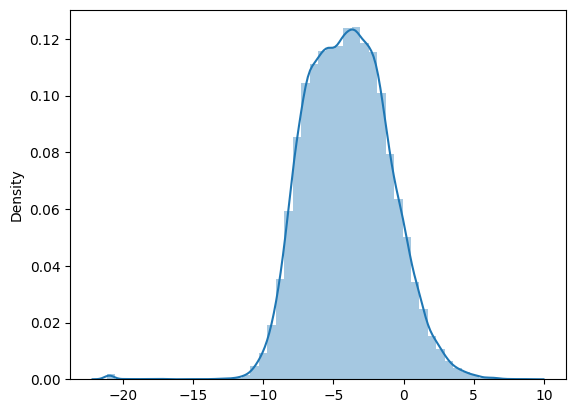

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.distplot(output.logits[0,-1,:].to('cpu').numpy())
plt.show()

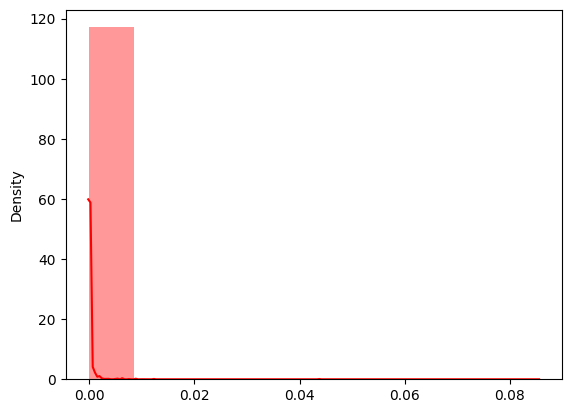

In [ ]:
normalized_logits = torch.softmax(output.logits[0,-1,:], dim=-1)
sns.distplot(normalized_logits.to('cpu').numpy(), color='red', bins=10)
plt.show()

In [ ]:
torch.argsort(next_token_probs, dim=-1, descending=True)

tensor([ 749,  691, 1266,  ...,  195,  208,  181], device='cuda:0')

## a

In [ ]:
input_text= "Transformers are the"
tokenized_ids= tokenizer(input_text, return_tensors='pt')['input_ids'].to(device)
print("tokenized_ids : ", tokenized_ids)
output= model.generate(tokenized_ids, max_new_tokens=8, do_sample=False)
print("output : ", output)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tokenized_ids :  tensor([[41762,   364,   389,   262]], device='cuda:0')
output :  tensor([[41762,   364,   389,   262,   749,  2968, 13373,  1627,   287,   262,
           995,    11]], device='cuda:0')
Transformers are the most popular toy line in the world,


In [ ]:
output

tensor([[41762,   364,   389,   262,   749,  2968, 13373,  1627,   287,   262,
           995,    11]], device='cuda:0')

In [ ]:
from pprint import pprint

In [ ]:
%%time
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
pprint(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


('In a shocking finding, scientist discovered a herd of unicorns living in a '
 'remote, previously unexplored valley, in the Andes Mountains. Even more '
 'surprising to the \r'
 'esearchers was the fact that the unicorns spoke perfect English.\n'
 '\n'
 '\n'
 'The researchers, from the University of California, Davis, and the '
 'University of Colorado, Boulder, were conducting a study on the Andean cloud '
 'forest, which is home to the rare species of cloud forest trees.\n'
 '\n'
 '\n'
 'The researchers were conducting a study on the Andean cloud forest, which is '
 'home to the rare species of cloud forest trees.\n'
 '\n'
 'The researchers were conducting a study on')
CPU times: user 3.53 s, sys: 4.68 ms, total: 3.53 s
Wall time: 3.61 s


# Beam Search Decoding

In [ ]:
%%time
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_beam = model.generate(input_ids, max_length=max_length, do_sample=False, num_beams=5)
pprint(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


('In a shocking finding, scientist discovered a herd of unicorns living in a '
 'remote, previously unexplored valley, in the Andes Mountains. Even more '
 'surprising to the \r'
 'esearchers was the fact that the unicorns spoke perfect English.\n'
 '\n'
 '\n'
 'The researchers, from the University of California, Davis, and the '
 'University of Colorado, Boulder, were conducting a study on the Andean cloud '
 'forest, which is home to the rare species of cloud forest trees.\n'
 '\n'
 '\n'
 'The researchers were conducting a study on the Andean cloud forest, which is '
 'home to the rare species of cloud forest trees.\n'
 '\n'
 'The researchers were conducting a study on')
CPU times: user 3.97 s, sys: 4.6 ms, total: 3.97 s
Wall time: 4.04 s


In [ ]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
        output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob

In [ ]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

esearchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.

The researchers were conducting a study on

log-prob: -70.03


In [ ]:
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

esearchers was the fact that the unicorns spoke perfect English.


The discovery of the unicorns was made by a team of scientists from the University of California, Davis, and the University of Colorado, Boulder, who were conducting a study of the Andes Mountains.


According to the scientists, the unicorns were living in a remote valley in the Andes Mountains, in the Andes Mountains, in the Andes Mountains, in the Andes

log-prob: -71.82


In [ ]:
# no_repeat_ngram_size: to avoid repeating n-gram
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


esearchers was the fact that the unicorns spoke perfect English.


The discovery was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society. The team, led by Dr. John Marzluff, a professor of biology at UCSC, had been conducting research in Peru for the past two years.

"We had no idea that there was a unicorn population in this area," said the team's leader

log-prob: -97.75


# Temperature

In [ ]:
input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
max_len= 1

In [ ]:

# def get_probs_temp(input_txt, temperature):
#     with torch.no_grad():
#         tokenized_data= tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)
#         output_logits = model(tokenized_data, temperature = temperature).logits
#         next_token_logits = output_logits[0, -1, :]
#         # next_token_probs = torch.softmax(next_token_logits, dim=-1) #sorted probs
#         sorted_probs = torch.sort(next_token_logits,  descending=True)
#     return sorted_probs

# input_txt = "Transformers are the"
# temp_0_5 =  get_probs_temp(input_txt, temperature=0.5)[0].to('cpu').numpy() # (value, indices)
# temp_1 =  get_probs_temp(input_txt, temperature=1)[0].to('cpu').numpy()
# temp_2 =  get_probs_temp(input_txt, temperature=2)[0].to('cpu').numpy()

In [ ]:
def get_probs_temp(input_txt,n_steps, temperature):
    with torch.no_grad():
        input_idss= input_ids
        for _ in range(n_steps):
            # tokenized_data= tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)
            # output_logits = model(input_ids=input_ids)
            output_logits = model(input_ids= input_idss, temperature = temperature).logits
            next_token_logits = output_logits[0, -1, :]
            next_token_probs = torch.softmax(next_token_logits, dim=-1) #sorted probs
            sorted_probs= torch.sort(next_token_probs, descending=True)[0].to("cpu").numpy()
            sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
            input_idss = torch.cat([input_idss, sorted_ids[None, 0, None]], dim=-1)
        return input_idss,sorted_probs



input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
_ , temp_0_5 =  get_probs_temp(input_txt, n_steps=8, temperature=0.5)
_ , temp_1 =  get_probs_temp(input_txt, n_steps=8, temperature=1)
_ , temp_2 =  get_probs_temp(input_txt, n_steps=8, temperature=14)


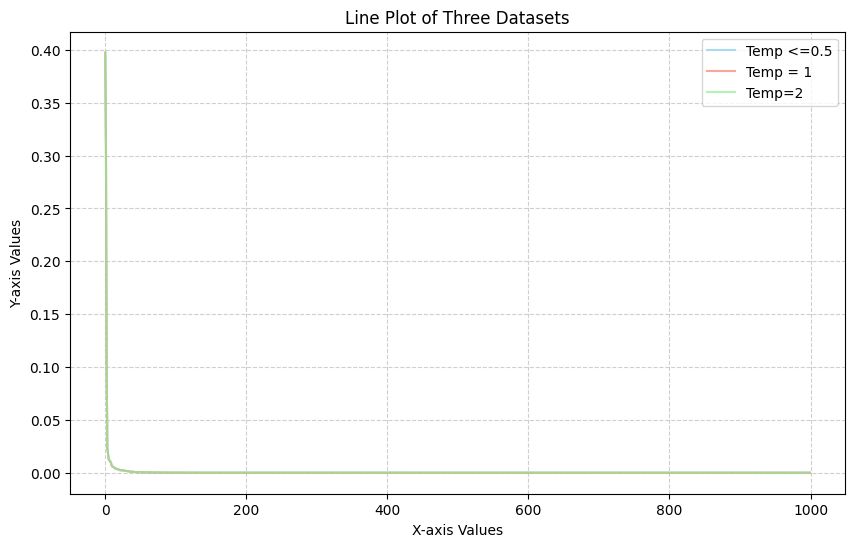

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # While imported, not strictly needed for a basic line plot here

# Define colors and labels for each line
colors = ['skyblue', 'salmon', 'lightgreen']
labels = ['Temp <=0.5', 'Temp = 1', 'Temp=2']

# Plot the lines
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

plt.plot(range(len(temp_0_5))[:1000], temp_0_5[:1000], color=colors[0], alpha=0.7, label=labels[0])
plt.plot(range(len(temp_1))[:1000], temp_1[:1000], color=colors[1], alpha=0.7, label=labels[1])
plt.plot(range(len(temp_2))[:1000], temp_2[:1000], color=colors[2], alpha=0.7, label=labels[2])

# Add labels and title
plt.xlabel("X-axis Values")
plt.ylabel("Y-axis Values")
plt.title("Line Plot of Three Datasets")

# Add a legend to distinguish the lines
plt.legend()

# Show the plot
plt.grid(True, linestyle='--', alpha=0.6) # Optional: Add a grid
plt.show()


In [ ]:
input_txt = "Transformers are the"
inputs = tokenizer(input_txt, return_tensors="pt").to(device)
inputs


def get_probs_temp(input_txt,n_steps, temperature):
    inputs= tokenizer(input_txt, return_tensors='pt').to(device)
    outputs = model.generate(**inputs, max_new_tokens=5, return_dict_in_generate=True, output_scores=True)
    transition_scores = model.compute_transition_scores(outputs.sequences, outputs.scores, normalize_logits=True)
    return outputs.scores[0]



{'input_ids': tensor([[41762,   364,   389,   262]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1]], device='cuda:0')}

In [ ]:
outputs = model.generate(**inputs, max_new_tokens=5, return_dict_in_generate=True, output_scores=True, temperature=2)
transition_scores = model.compute_transition_scores(outputs.sequences, outputs.scores, normalize_logits=True)

input_length = inputs.input_ids.shape[1]
generated_tokens = outputs.sequences[:, input_length:]
# for tok, score in zip(generated_tokens[0], transition_scores[0]):
#     # | token | token string | logits | probability
#     print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.4f} | {np.exp(score.numpy()):.2%}")
# Expected output:
#|   262 |  the     | -1.4136 | 24.33%
#|  1110 |  day     | -2.6089 | 7.36%
#|   618 |  when    | -2.0096 | 13.40%
#|   356 |  we      | -1.8593 | 15.58%
#|   460 |  can     | -2.5083 | 8.14%

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
transition_scores, outputs.scores[0].shape

(tensor([[-2.4610, -1.7848, -2.2417, -1.0678, -0.7704]], device='cuda:0'),
 torch.Size([1, 50257]))

In [ ]:
soft2= torch.softmax( outputs.scores[0], dim=-1)
soft_sort2= torch.sort(soft2, descending=True)
print(soft_sort2[0])

tensor([[8.5346e-02, 4.9640e-02, 4.6514e-02,  ..., 7.3002e-15, 7.2986e-15,
         7.2014e-15]], device='cuda:0')


In [ ]:
soft= torch.softmax(  outputs.scores[0], dim=-1)
soft_sort= torch.sort(soft, descending=True)
print(soft_sort[0])

tensor([[8.5346e-02, 4.9640e-02, 4.6514e-02,  ..., 7.3002e-15, 7.2986e-15,
         7.2014e-15]], device='cuda:0')


In [ ]:
soft[0].sum(), range(len(soft[0]))

(tensor(1., device='cuda:0'), range(0, 50257))

<Axes: >

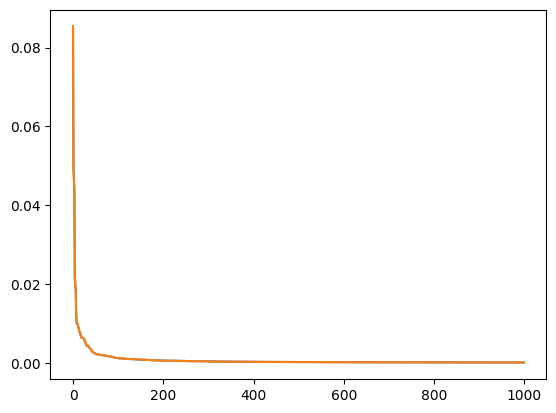

In [ ]:
sns.lineplot(x=range(len(soft_sort[0][0]))[:1000], y=soft_sort[0][0][:1000].to("cpu").numpy())
sns.lineplot(x=range(len(soft_sort2[0][0]))[:1000], y=soft_sort2[0][0][:1000].to("cpu").numpy())

In [ ]:
outputs.scores[0][0]

tensor([ 0.3186,  0.8100, -2.9974,  ..., -3.2712, -4.3837,  0.8114],
       device='cuda:0')

In [ ]:
tokenizer.decode(generated_tokens[0])

' most popular toy line in'